In [3]:
import xarray as xr
from saveCore_standalone_NFLICS import run_powerBlobs, powerBlob_utils, util
import ccores.cores as cores
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import os
from utils import u_darrays as uda
from eod import msg_panAfrica
from utils import u_grid, u_interpolate as u_int
import glob
from utils import constants as cnst
import ipdb
from utils import u_interpolate_small as uint

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [6]:
ds = xr.open_dataset('/media/ck/LStorage/global_water/other/nflics/SSA_data/data/ch9_wavelet/2010/11/201011041845.nc')

In [11]:
lpath = glob.glob(msg_folder+'grads/*.npz')[0]
msg_latlon = np.load(lpath)
mlon = msg_latlon['lon']
mlat = msg_latlon['lat']

<xarray.DataArray 'tir' (lat: 2080, lon: 2268)>
array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [21, 21, 21, ...,  0,  0,  0],
       [21, 21, 21, ...,  0,  0,  0],
       [21, 21, 21, ...,  0,  0,  0]], dtype=int8)
Coordinates:
    time     datetime64[ns] 2010-11-04T18:45:00
  * lat      (lat) float32 -37.56 -37.52 -37.48 -37.44 ... 24.8 24.83 24.87 24.9
  * lon      (lon) float32 -27.16 -27.12 -27.08 -27.03 ... -1e+03 -1e+03 -1e+03

In [13]:
ds.lon

<xarray.DataArray 'lon' (lon: 2268)>
array([ -27.161226,  -27.11858 ,  -27.075876, ..., -999.999   , -999.999   ,
       -999.999   ], dtype=float32)
Coordinates:
  * lon      (lon) float32 -27.16 -27.12 -27.08 -27.03 ... -1e+03 -1e+03 -1e+03

In [5]:
## a clean way of plotting - use matplotlib functions directly:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
def draw_map(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
 #   ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)

In [8]:
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
#draw_map(ax, ds['t'], ds.lon, ds.lat, levels=np.arange(-100,50), cmap='jet')
draw_map(ax, ds['tir'].isel(time=0), ds.lon, ds.lat, levels=np.arange(-100,50), cmap='jet')
ax.set_ylim(-38,28)
ax.set_xlim(-23,52)

GEOSException: TopologyException: side location conflict at -999.9990234375 -19.541507720947266. This can occur if the input geometry is invalid.

Error in callback <function _draw_all_if_interactive at 0x7ff15f76cdc0> (for post_execute):


GEOSException: TopologyException: side location conflict at -999.9990234375 -19.541507720947266. This can occur if the input geometry is invalid.

GEOSException: TopologyException: side location conflict at -999.9990234375 -19.541507720947266. This can occur if the input geometry is invalid.

<Figure size 1500x700 with 1 Axes>

In [1]:
import pickle as pkl

#### loads [ickle file with saved rain distribution for original rainfall in domain (native) and rainfall co-located with core locations at different resolutions

strt = {}
for dat in ['3km LS, 3k weighting', '3km LS, nflics weighting',  '3km small, 3kweighting', '3km LS, 3k regridded, 3k weighting', '5k, nflics', '5k LS definition, nflics weighting','3k native rain', '3k regrid rain', '5k rain']:
    strt[dat]=pkl.load(open("/home/ck/DIR/cornkle/data/nflics/core_tests/"+dat+".p", "rb"))

keys = strt.keys()
    

In [2]:
# calculate frequency of rainfall above a threshold 

def calc_treshReached(dat, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.isfinite(dat))

In [3]:
# calculate frequency of rainfall above a threshold relative to the same frequency for the full rainfall field (native)

def calc_treshReached_vsObs(dat, obs, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.isfinite(dat)) / np.sum(np.array(obs)>thresh)/np.sum(np.isfinite(obs))

In [4]:
# calculate fraction of missed rainfall pixels above a threshold

def calc_treshMissed(dat, obs, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.array(obs)>thresh)

In [5]:
# calculate frequency of rainfall above a threshold for regions with wavelet power above a given percentile

def percentile(dat, wav, thresh, perc):
    pval = np.percentile(wav, perc)
    dats = np.array(dat)[np.array(wav)>=pval]
    return np.sum(dats>thresh)/np.sum(np.isfinite(dats))

In [8]:
treached = []
tnames = []
for kk in strt.keys():
    try:
        dat = strt[kk]['rain']
    except:
        dat = strt[kk]
    cc = calc_treshReached(dat,20)
    print(cc, kk)
    treached.append(cc)
    tnames.append(kk)

0.035083690494330855 3km LS, 3k weighting
0.02482111651287514 3km LS, nflics weighting
0.030337206319278557 3km small, 3kweighting
0.027049229939923362 3km LS, 3k regridded, 3k weighting
0.01708474236520757 5k, nflics
0.018535332136203755 5k LS definition, nflics weighting
0.007896279230061157 3k native rain
0.005558069276729324 3k regrid rain
0.005558382945938996 5k rain


In [656]:
# #save percentiles for filter or contour use
# for dat in [(k3LS, '3km LS, 3k weighting'), (k3LS_grid, '3km LS, nflics weighting'), (k3, '3km small, 3kweighting'), (k3LS_nflics, '3km LS, 3k regridded, 3k weighting'), (nflics, '5k, nflics'), (nflicsLS, '5k LS definition, nflics weighting')]:
#     perc = np.percentile(dat[0]['wav'], np.arange(50,100,5))
#     print(perc)
#     pkl.dump(perc, open("/home/ck/DIR/cornkle/data/nflics/core_tests/"+dat[1]+"_50-95_5step_percentiles.p", "wb"))

[145.68925912 154.6045336  164.40441867 175.49540259 188.14664331
 202.78138813 219.82352822 241.0763581  270.31755423 316.79180866]
[102.74613829 111.73680907 121.8930548  133.27193065 146.28414377
 161.59669112 180.14323807 203.33182855 233.80664645 283.38017364]
[281.94459958 297.05066143 313.73431319 332.4328058  353.72631993
 378.22639069 407.24986078 443.01907842 490.6509716  567.7480026 ]
[142.26155914 150.72534661 160.10214619 170.65636706 182.75239252
 196.54562398 212.96568346 233.51007126 262.24086651 308.59514012]
[ 39.83819145  44.06957418  48.95269823  54.68772905  61.54554385
  69.90648702  80.55575274  94.77742261 115.38045487 151.78379602]
[ 81.36445366  89.23964238  98.27792328 108.54026771 120.40546614
 134.19061669 150.97449914 173.15149292 204.38659597 255.72803878]


In [ ]:
tcaught = []
for kk in strt.keys():
    try:
        dat = strt[kk]['rain']
    except:
        continue
    if '3k' in kk:
        ipdb.set_trace()
        precip  = strt['3k native rain']
    else:
        precip = strt['5k rain']
    
    cc = calc_treshMissed(dat,precip, 30)
    print(cc, dat, len(dat))
    tcaught.append(cc)

> <ipython-input-18-91b8225d7357>(9)<module>()
      8         ipdb.set_trace()
----> 9         precip  = strt['3k native rain']
     10     else:

ipdb> strt['3k native rain']


In [613]:
tfrac = []
for dat in [(k3LS['rain'], '3km LS, 3k weighting', alls3k), (k3LS_grid['rain'], '3km LS, nflics weighting', alls3k), (k3['rain'], '3km small, 3kweighting', alls3k), (k3LS_nflics['rain'], '3km LS, 3k regridded, 3k weighting', alls3k_reg), (nflics['rain'], '5k, nflics', alls5k), (nflicsLS['rain'], '5k LS definition, nflics weighting', alls5k)]:

    cc = calc_treshReached_vsObs(dat[0],dat[2], 25)
    print(cc, dat[1])
    tfrac.append(cc)

2.9040804540859075e-14 3km LS, 3k weighting
2.0591490639522683e-14 3km LS, nflics weighting
2.520622479993889e-14 3km small, 3kweighting
2.478752692238593e-14 3km LS, 3k regridded, 3k weighting
1.2352462035933699e-13 5k, nflics
1.3468025093351036e-13 5k LS definition, nflics weighting


In [589]:
for tr, tc, tn in zip(treached,tcaught,tnames):
    print(tr*tc, tn)

0.006550512212183412 3km LS, 3k weighting
0.005498732818136278 3km LS, nflics weighting
0.005985859042224944 3km small, 3kweighting
0.004189964632383902 3km LS, 3k regridded, 3k weighting
0.0026050795786471763 5k, nflics
0.003574765559954474 5k LS definition, nflics weighting


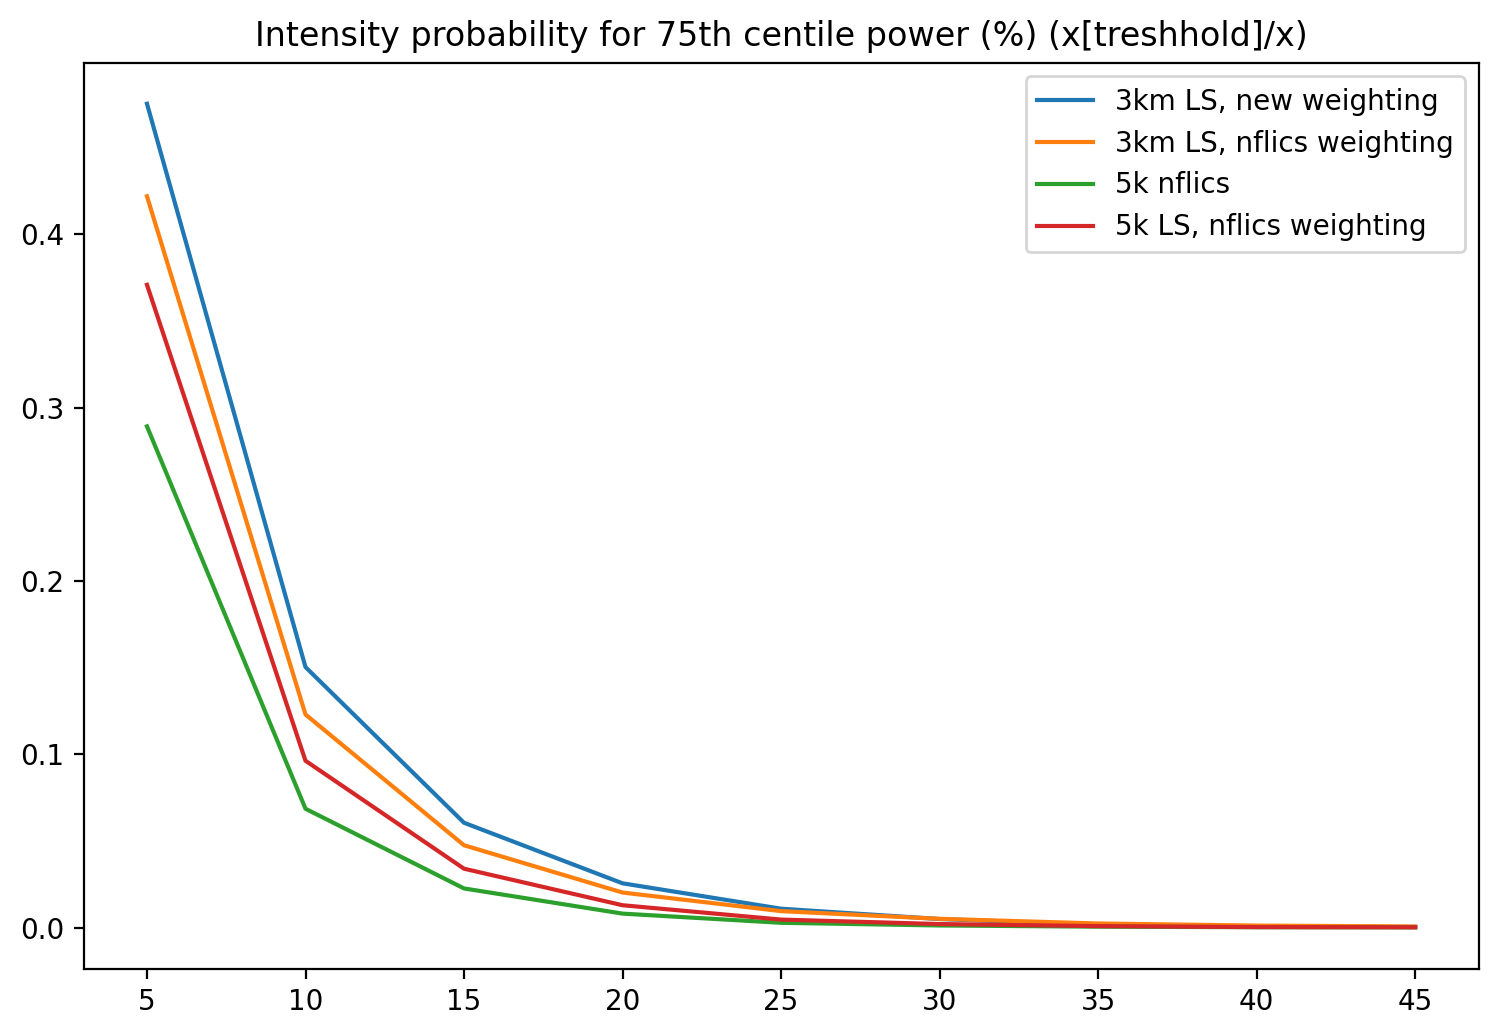

In [83]:
f = plt.figure(figsize=(9,6), dpi=200)
ax = f.add_subplot(111)
plotdic = []
for dat in [(k3LS, '3km LS, new weighting'), (k3LS_grid, '3km LS, nflics weighting'), (nflics, '5k nflics'), (nflicsLS, '5k LS, nflics weighting')]:
    treached = []
    for intens in range(5,50,5):
        cc = percentile(dat[0]['rain'],dat[0]['wav'], intens, 75)
        treached.append(cc)
    plotdic.append((treached,dat[1]))

for pp in plotdic:    
    ax.plot(range(5,50,5), pp[0], label=pp[1])

ax.set_title("Intensity probability for 75th centile power (%) (x[treshhold]/x)")
plt.legend()
#f.savefig("/home/ck/DIR/cornkle/data/nflics/core_tests/"+'rainP_75p_wpower.jpg')

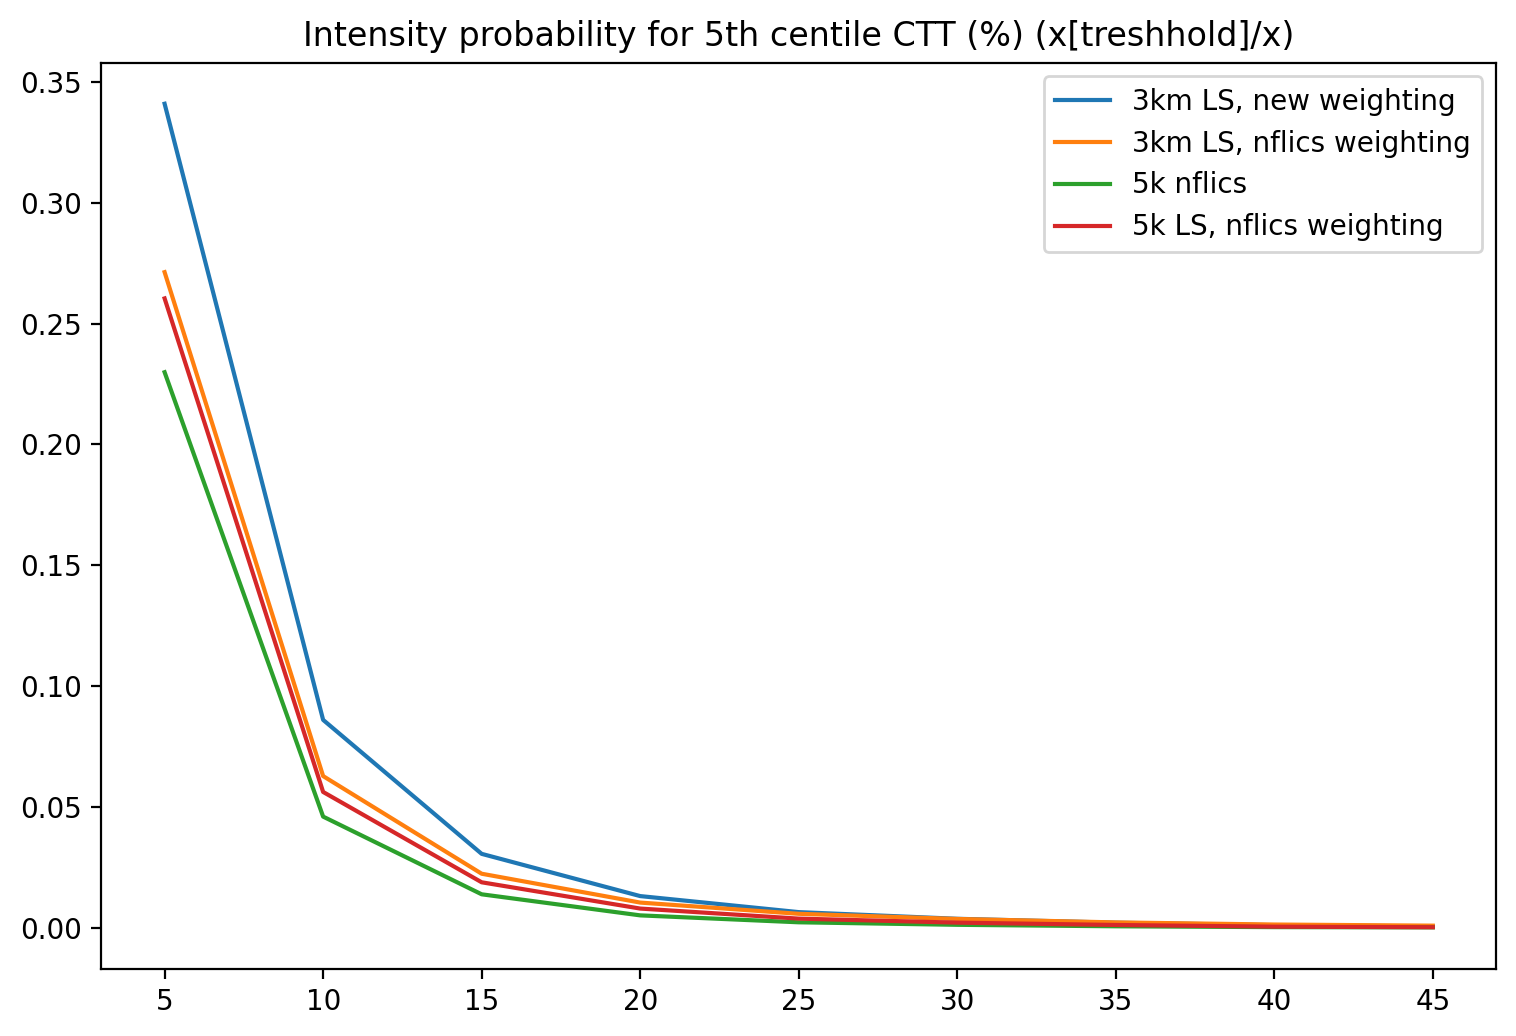

In [84]:
f = plt.figure(figsize=(9,6), dpi=200)
ax = f.add_subplot(111)
plotdic = []
for dat in [(k3LS, '3km LS, new weighting'), (k3LS_grid, '3km LS, nflics weighting'),  (nflics, '5k nflics'), (nflicsLS, '5k LS, nflics weighting')]:
    treached = []
    for intens in range(5,50,5):
        cc = percentile(dat[0]['rain'],dat[0]['t'], intens, 5)
        treached.append(cc)
    plotdic.append((treached,dat[1]))

for pp in plotdic:    
    ax.plot(range(5,50,5), pp[0], label=pp[1])

ax.set_title("Intensity probability for 5th centile CTT (%) (x[treshhold]/x)")
plt.legend()
#f.savefig("/home/ck/DIR/cornkle/data/nflics/core_tests/"+'rainP_5pCTT.jpg')

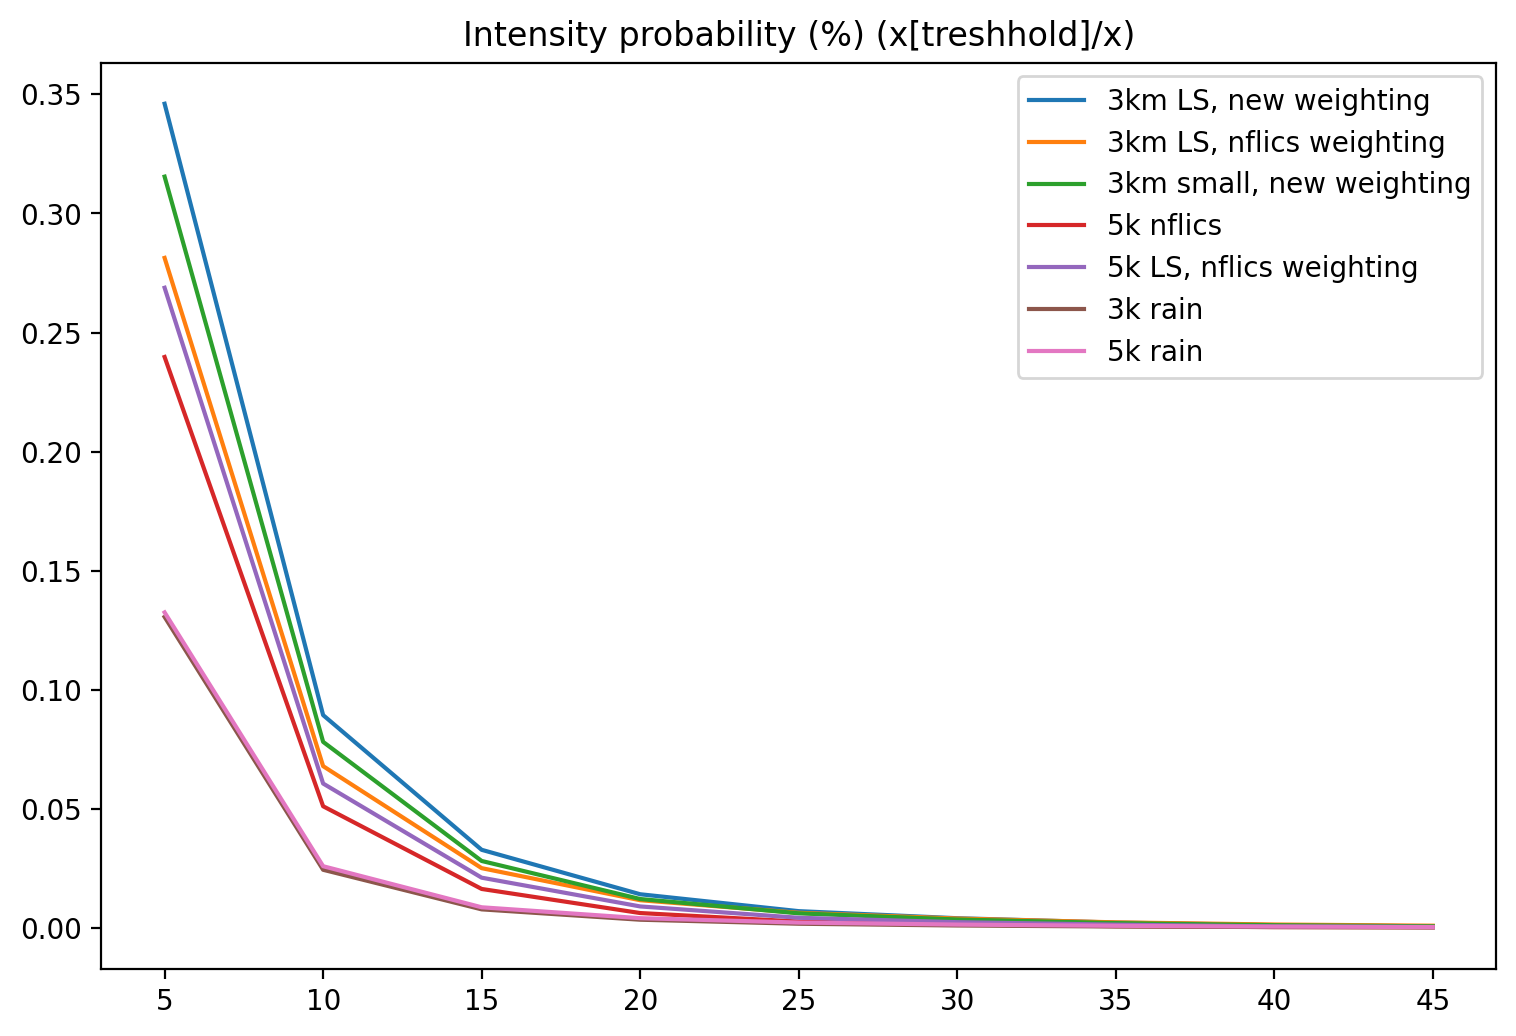

In [116]:
f = plt.figure(figsize=(9,6), dpi=200)
ax = f.add_subplot(111)
plotdic = []
for dat in [(k3LS['rain'], '3km LS, new weighting'), (k3LS_grid['rain'], '3km LS, nflics weighting'),(k3['rain'], '3km small, new weighting'), (nflics['rain'], '5k nflics'), (nflicsLS['rain'], '5k LS, nflics weighting'), (alls3k, '3k rain'), (alls5k, '5k rain')]:
    treached = []
    for intens in range(5,50,5):
        cc = calc_treshReached(dat[0],intens)
        treached.append(cc)
    plotdic.append((treached,dat[1]))

for pp in plotdic:    
    ax.plot(range(5,50,5), pp[0], label=pp[1])

ax.set_title("Intensity probability (%) (x[treshhold]/x)")
plt.legend()
 
#f.savefig("/home/ck/DIR/cornkle/data/nflics/core_tests/"+'rainP_95p_rainWav_southernAfricadomain.jpg')     

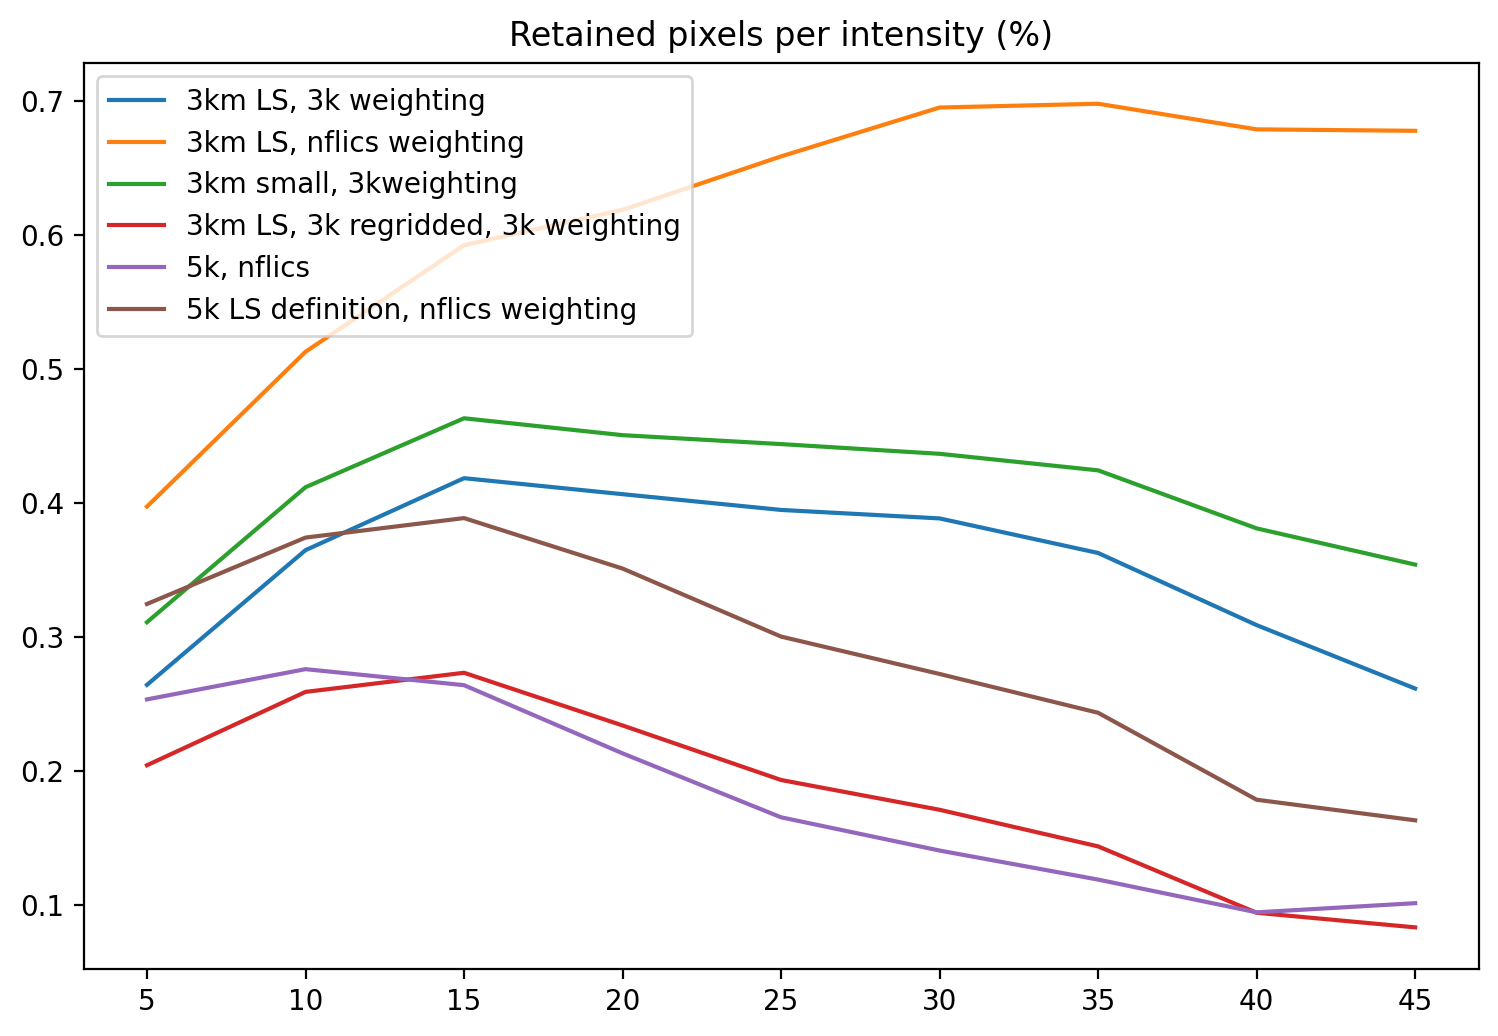

In [89]:
f = plt.figure(figsize=(9,6), dpi=200)
ax = f.add_subplot(111)
plotdic = []
for dat in [(k3LS['rain'], '3km LS, 3k weighting', alls3k), (k3LS_grid['rain'], '3km LS, nflics weighting', alls3k), (k3['rain'], '3km small, 3kweighting', alls3k), (k3LS_nflics['rain'], '3km LS, 3k regridded, 3k weighting', alls3k_reg), (nflics['rain'], '5k, nflics', alls5k), (nflicsLS['rain'], '5k LS definition, nflics weighting', alls5k)]:
    treached = []
    for intens in range(5,50,5):
        cc = calc_treshMissed(dat[0],dat[2],intens)
        treached.append(cc)
    plotdic.append((treached,dat[1]))

for pp in plotdic:    
    ax.plot(range(5,50,5), pp[0], label=pp[1])

ax.set_title("Retained pixels per intensity (%)")
plt.legend()
 
f.savefig("/home/ck/DIR/cornkle/data/nflics/core_tests/"+'_missedCases_southernAfricaDomain.jpg')     